# CodeBERTScore Analysis (updated schema)

Analyze similarity results with the new CSV format that includes `prompt_level`, `Processor`, and normalized `Model` values (phi4, qw32, gpt5).

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np 

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

BOX_KWARGS = {
    "showmeans": True,
    "meanprops": {"marker": "x", "markeredgecolor": "black", "markersize": 7, "linestyle": "none"},
    "medianprops": {"color": "black", "linewidth": 2},
    "whiskerprops": {"color": "black", "linewidth": 1.5},
    "capprops": {"color": "black", "linewidth": 1.5},
    "flierprops": {"marker": "o", "markerfacecolor": "gray", "markeredgecolor": "gray", "markersize": 4, "alpha": 0.8},
    # Keep palette facecolors; only style edges.
    "boxprops": {"edgecolor": "black", "linewidth": 1.5},
}
COLOR_PALETTE = sns.color_palette("Set2")

SCRIPT_DIR = Path.cwd()
PROJECT_ROOT = SCRIPT_DIR.parent.parent if SCRIPT_DIR.name == "analyser-results" else SCRIPT_DIR
DATASETS = {
    "psg": PROJECT_ROOT / "codebertscore-similarity/analyser-results/similarity_results_psg.csv",
    "sg": PROJECT_ROOT / "codebertscore-similarity/analyser-results/similarity_results_sg.csv",
    "tpusg": PROJECT_ROOT / "codebertscore-similarity/analyser-results/similarity_results_tpusg.csv",
}
required_cols = ["Candidate_ID", "Model", "prompt_level", "Precision", "Recall", "F1", "F3", "Processor"]

## Load Data

In [154]:
frames = []
missing = []
for proc, path in DATASETS.items():
    if not path.exists():
        missing.append(f"{proc}: {path}")
        continue
    df_part = pd.read_csv(path)
    df_part["Processor"] = proc  # enforce processor label
    frames.append(df_part)

if missing:
    print("Missing datasets:")
    for m in missing:
        print(m)

df = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame(columns=required_cols)
df.head()

,Candidate_ID,Model,Precision,Recall,F1,F3,Processor,prompt_level
0,data_analysis/2026/02.03_gpt5-mpu/exported_val...,gpt5,0.792295,0.867710,0.828290,0.859529,psg,original
1,data_analysis/2026/02.03_gpt5-mpu/exported_val...,gpt5,0.784481,0.873618,0.826654,0.863803,psg,original
2,data_analysis/2026/02.03_gpt5-mpu/exported_val...,gpt5,0.784981,0.876138,0.828058,0.866081,psg,original
3,data_analysis/2026/02.03_gpt5-mpu/exported_val...,gpt5,0.781000,0.864467,0.820617,0.855326,psg,original
4,data_analysis/2026/02.03_gpt5-mpu/exported_val...,gpt5,0.777338,0.871617,0.821782,0.861172,psg,original


## Clean and normalize columns

In [155]:
def parse_model_fields(raw_model):
    text = str(raw_model)
    if "_" in text:
        _, text = text.split("_", 1)
    prompt_level = "abla-l1" if "abla-l1" in text else "abla-l2" if "abla-l2" in text else "original"
    base_model = next((m for m in ("phi4", "qw32", "gpt5") if m in text), text.split("-")[0])
    return base_model, prompt_level

valid_prompts = {"abla-l1", "abla-l2", "original"}

def normalize_row(row):
    base_model, inferred_prompt = parse_model_fields(row.get("Model", ""))
    raw_prompt = row.get("prompt_level", "")
    prompt = raw_prompt if str(raw_prompt) in valid_prompts else inferred_prompt
    return pd.Series({"Model": base_model, "prompt_level": prompt})

if df.empty:
    print("No data loaded; check dataset paths.")
else:
    normalized = df.apply(normalize_row, axis=1)
    df["Model"] = normalized["Model"]
    df["prompt_level"] = normalized["prompt_level"]
    df = df[required_cols]
df.head()

,Candidate_ID,Model,prompt_level,Precision,Recall,F1,F3,Processor
0,data_analysis/2026/02.03_gpt5-mpu/exported_val...,gpt5,original,0.792295,0.867710,0.828290,0.859529,psg
1,data_analysis/2026/02.03_gpt5-mpu/exported_val...,gpt5,original,0.784481,0.873618,0.826654,0.863803,psg
2,data_analysis/2026/02.03_gpt5-mpu/exported_val...,gpt5,original,0.784981,0.876138,0.828058,0.866081,psg
3,data_analysis/2026/02.03_gpt5-mpu/exported_val...,gpt5,original,0.781000,0.864467,0.820617,0.855326,psg
4,data_analysis/2026/02.03_gpt5-mpu/exported_val...,gpt5,original,0.777338,0.871617,0.821782,0.861172,psg


In [156]:
# Debug: find rows with missing/invalid Model and show their raw entries
frames_raw = []
for proc, path in DATASETS.items():
    if not path.exists():
        continue
    raw_part = pd.read_csv(path)
    raw_part["Processor"] = proc
    frames_raw.append(raw_part)
raw_df = pd.concat(frames_raw, ignore_index=True) if frames_raw else pd.DataFrame()

bad = df[df["Model"].isna() | df["Model"].astype(str).str.lower().eq("nan")]
if bad.empty:
    print("No rows with missing/invalid Model after normalization.")
else:
    print("Problem rows after normalization:")
    display(bad[["Candidate_ID", "Model", "prompt_level", "Processor"]])
    ids = set(bad["Candidate_ID"].astype(str))
    raw_bad = raw_df[raw_df["Candidate_ID"].astype(str).isin(ids)]
    print("Raw CSV rows for those candidates:")
    display(raw_bad)

No rows with missing/invalid Model after normalization.


## Summary by prompt_level → processor → model

In [157]:
if df.empty:
    summary = pd.DataFrame()
else:
    summary = (
        df.groupby(["prompt_level", "Processor", "Model"])[["Precision", "Recall", "F1", "F3"]]
        .agg(['mean', 'std', 'count'])
        .reset_index()
    )
summary

prompt_level Processor Model Precision                    Recall            \
                                    mean       std count      mean       std   
0     original       psg  gpt5  0.804479  0.019786    89  0.864640  0.006822   
1     original       psg  phi4  0.892000  0.021644    61  0.819399  0.062455   
2     original       psg  qw32  0.900646  0.010887    67  0.840750  0.012084   
3     original        sg  gpt5  0.827409  0.010325    54  0.866146  0.006710   
4     original     tpusg  gpt5  0.811224  0.012115    87  0.867518  0.005699   
5     original     tpusg  phi4  0.898289  0.011117    69  0.842898  0.009517   
6     original     tpusg  qw32  0.892537  0.010019    72  0.831266  0.012292   

               F1                        F3                  
  count      mean       std count      mean       std count  
0    89  0.833286  0.008810    89  0.858148  0.004881    89  
1    61  0.853211  0.046481    61  0.825853  0.059863    61  
2    67  0.869624  0.009794    67  0.846364  0.011470    67  
3    54  0.846310  0.007537    54  0.862100  0.006618    54  
4    87  0.838371  0.006952    87  0.861517  0.005213    87  
5    69  0.869659  0.007707    69  0.848110  0.008849    69  
6    72  0.860791  0.010472    72  0.837005  0.011869    72

## Boxplots: F1 by model, separated by prompt_level (hue=processor)

/tmp/ipykernel_2446511/116471884.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_2446511/116471884.py:29: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_2446511/116471884.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(


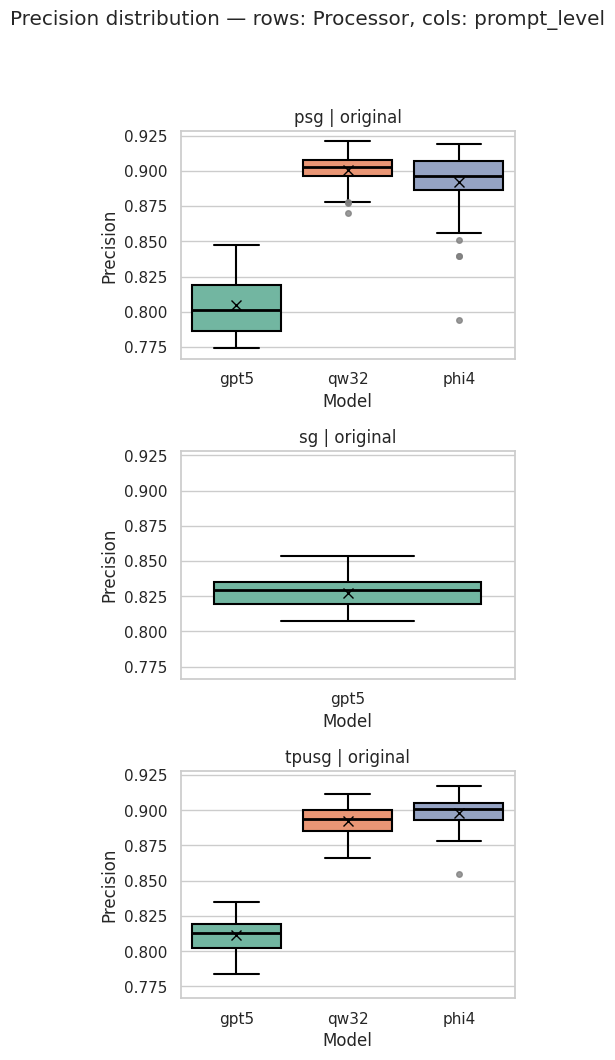

/tmp/ipykernel_2446511/116471884.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_2446511/116471884.py:29: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_2446511/116471884.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(


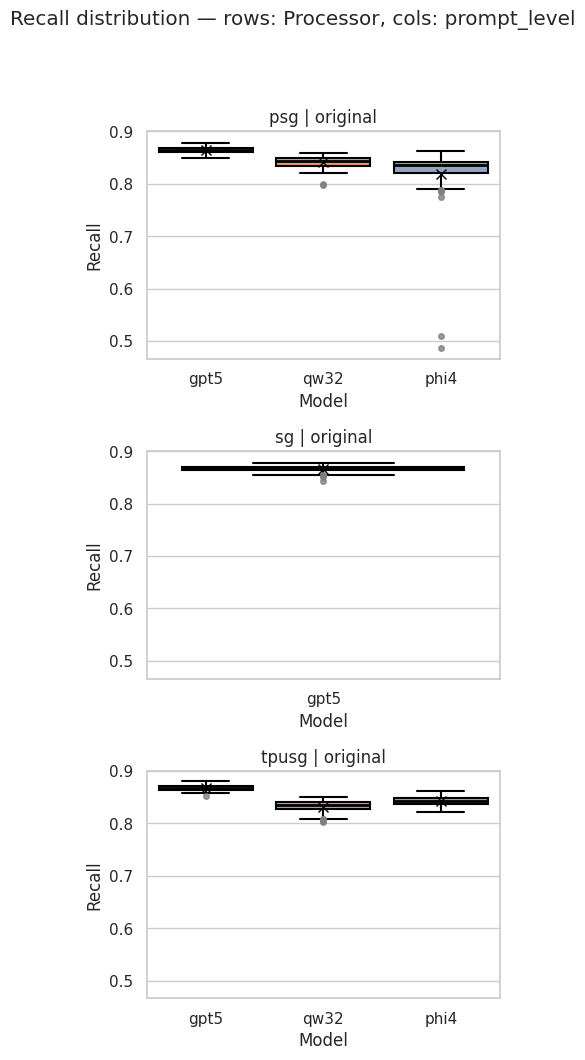

/tmp/ipykernel_2446511/116471884.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_2446511/116471884.py:29: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_2446511/116471884.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(


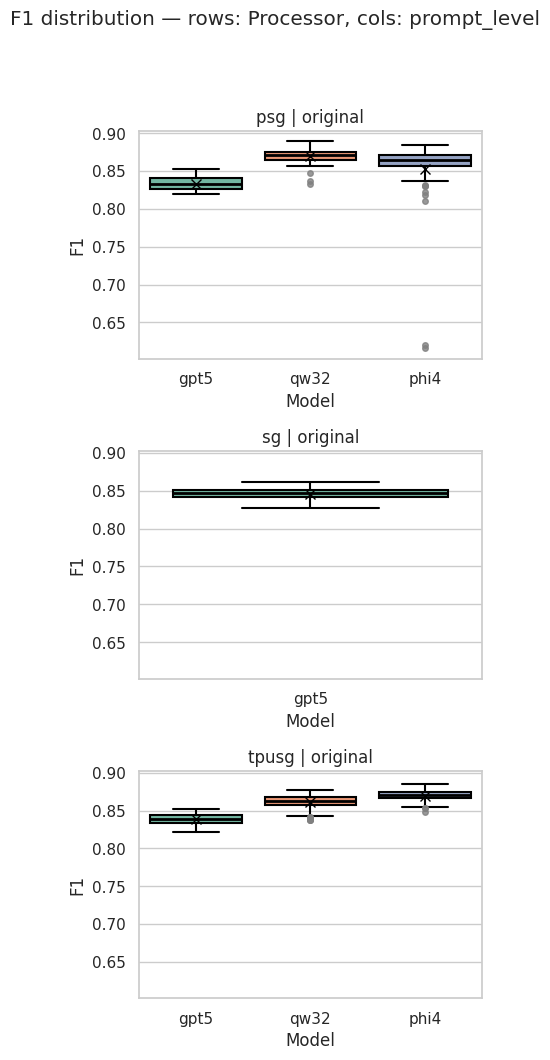

/tmp/ipykernel_2446511/116471884.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_2446511/116471884.py:29: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_2446511/116471884.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(


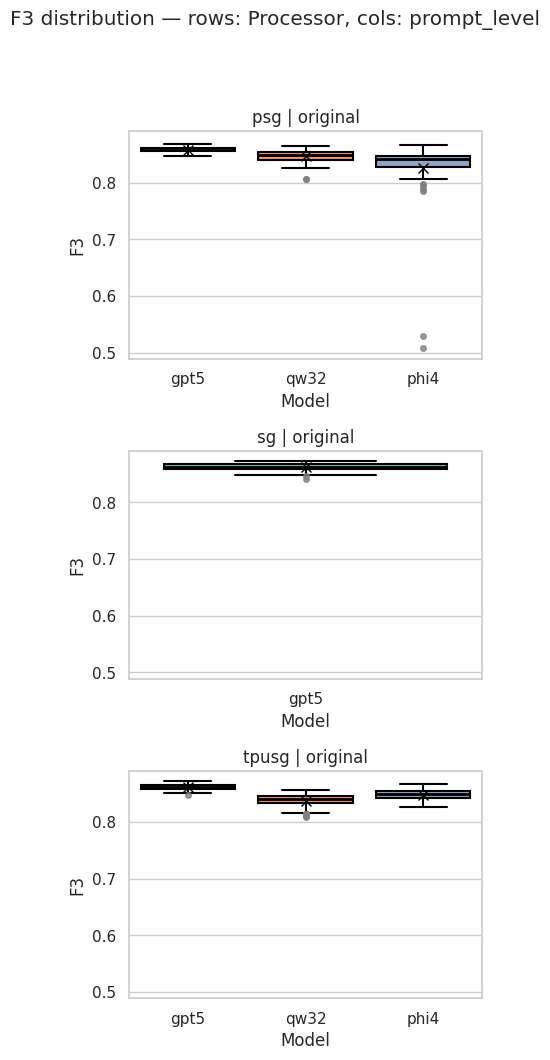

In [158]:
from matplotlib.lines import Line2D

if df.empty:
    print("No data to plot.")
else:
    metrics = ["Precision", "Recall", "F1", "F3"]
    processors = sorted(df["Processor"].unique())
    prompts = sorted(df["prompt_level"].unique())

    for metric in metrics:
        fig, axes = plt.subplots(
            nrows=len(processors),
            ncols=len(prompts),
            figsize=(len(prompts) * 4.5, len(processors) * 3.6),
            sharey=True,
        )
        axes = np.array(axes).reshape(len(processors), len(prompts))

        legend_handles = None
        legend_labels = None

        for i, proc in enumerate(processors):
            for j, prompt in enumerate(prompts):
                ax = axes[i, j]
                subset = df[(df["Processor"] == proc) & (df["prompt_level"] == prompt)]
                if subset.empty:
                    ax.set_visible(False)
                    continue
                sns.boxplot(
                    data=subset,
                    x="Model",
                    y=metric,
                    hue="Model",
                    palette=COLOR_PALETTE,
                    ax=ax,
                    **BOX_KWARGS,
                )
                ax.set_title(f"{proc} | {prompt}")
                ax.set_xlabel("Model")
                ax.set_ylabel(metric if j == 0 else "")
                # Capture legend handles/labels once
                if legend_handles is None and ax.get_legend():
                    legend_handles, legend_labels = ax.get_legend_handles_labels()
                if ax.get_legend():
                    ax.legend_.remove()

        if legend_handles:
            fig.legend(legend_handles, legend_labels, title="Model", loc="upper center", ncol=len(legend_labels))
        fig.suptitle(f"{metric} distribution — rows: Processor, cols: prompt_level", y=0.98)
        fig.tight_layout(rect=[0, 0, 1, 0.94])
        plt.show()


## Coverage and counts by prompt_level and processor

In [159]:
if df.empty:
    print("No data available.")
else:
    counts = df.groupby(["prompt_level", "Processor", "Model"]).size().reset_index(name="rows")
    counts_pivot = counts.pivot_table(values="rows", index=["prompt_level", "Processor"], columns="Model", fill_value=0)
    display(counts)
    display(counts_pivot)

,prompt_level,Processor,Model,rows
0,original,psg,gpt5,89
1,original,psg,phi4,61
2,original,psg,qw32,67
3,original,sg,gpt5,54
4,original,tpusg,gpt5,87
5,original,tpusg,phi4,69
6,original,tpusg,qw32,72


Model                   gpt5  phi4  qw32
prompt_level Processor                  
original     psg        89.0  61.0  67.0
             sg         54.0   0.0   0.0
             tpusg      87.0  69.0  72.0

## Top performers within each prompt_level and processor

In [160]:
if df.empty:
    print("No data available.")
else:
    top = (
        df.sort_values("F1", ascending=False)
        .groupby(["prompt_level", "Processor", "Model"])
        .head(3)
    )
    top[["prompt_level", "Processor", "Model", "Candidate_ID", "F1", "Precision", "Recall", "F3"]]

## Metric distributions by prompt_level

/tmp/ipykernel_2446511/3275227633.py:7: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(data=df, x="prompt_level", y=metric, hue="Processor", ax=ax, palette=COLOR_PALETTE, **BOX_KWARGS)
/tmp/ipykernel_2446511/3275227633.py:7: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(data=df, x="prompt_level", y=metric, hue="Processor", ax=ax, palette=COLOR_PALETTE, **BOX_KWARGS)
/tmp/ipykernel_2446511/3275227633.py:7: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(data=df, x="prompt_level", y=metric, hue="Processor", ax=ax, palette=COLOR_PALETTE, **BOX_KWARGS)
/tmp/ipykernel_2446511/3275227633.py:7: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(data=df, x="prompt_level", y=metric, hue="Processor", ax=ax, palette=COLOR_PALETTE, **BOX_KWARGS)


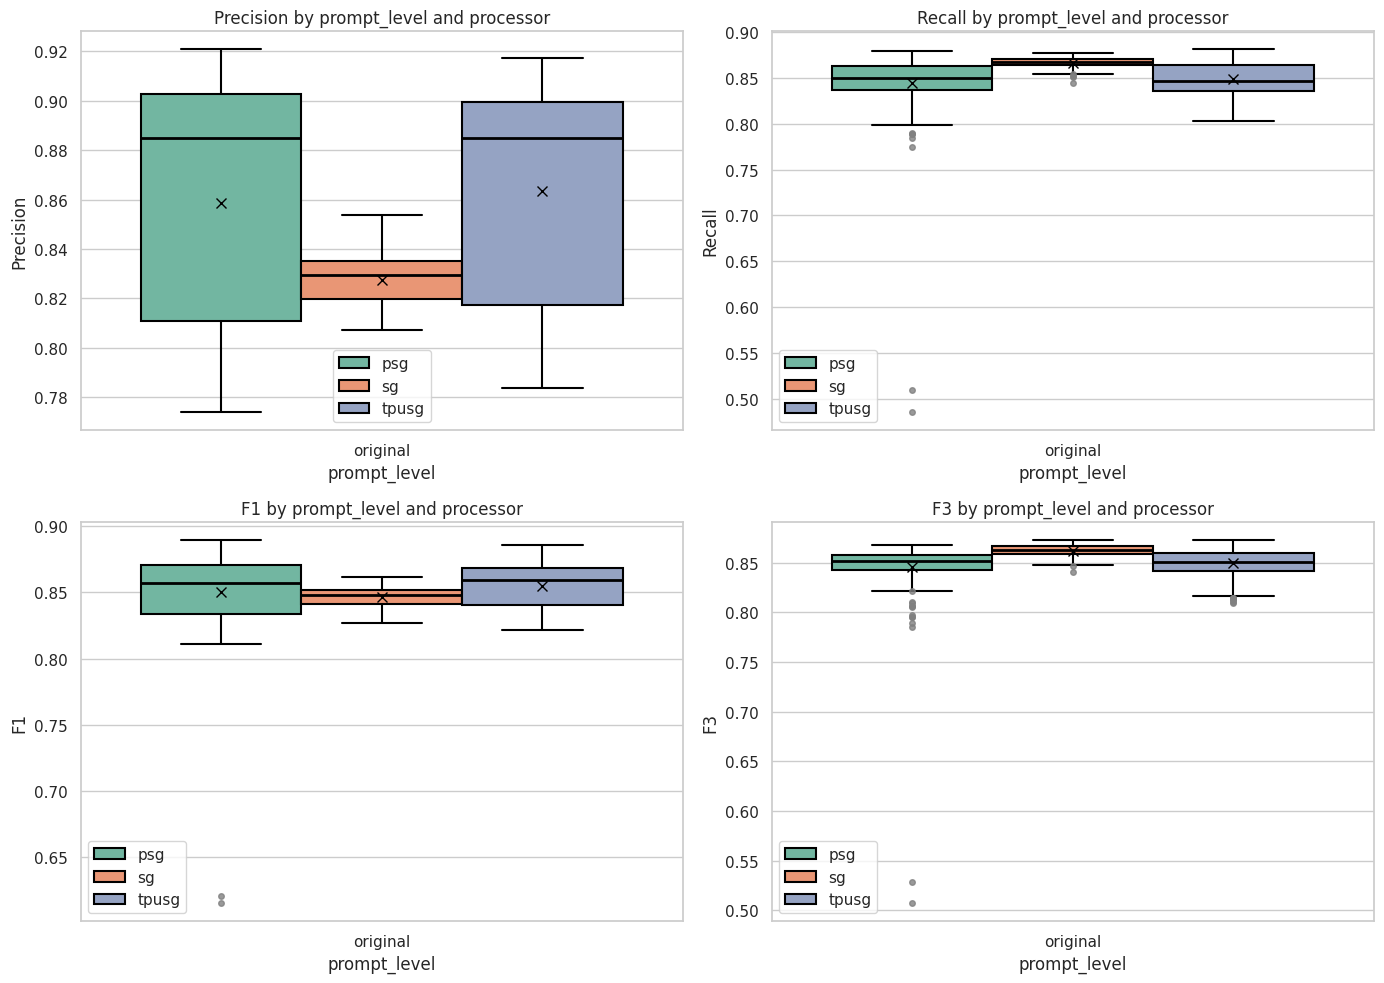

In [161]:
if df.empty:
    print("No data to plot.")
else:
    metrics = ["Precision", "Recall", "F1", "F3"]
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    for ax, metric in zip(axes.flat, metrics):
        sns.boxplot(data=df, x="prompt_level", y=metric, hue="Processor", ax=ax, palette=COLOR_PALETTE, **BOX_KWARGS)
        ax.set_title(f"{metric} by prompt_level and processor")
        ax.legend(loc="best")
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2446511/3087961975.py:7: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.catplot(


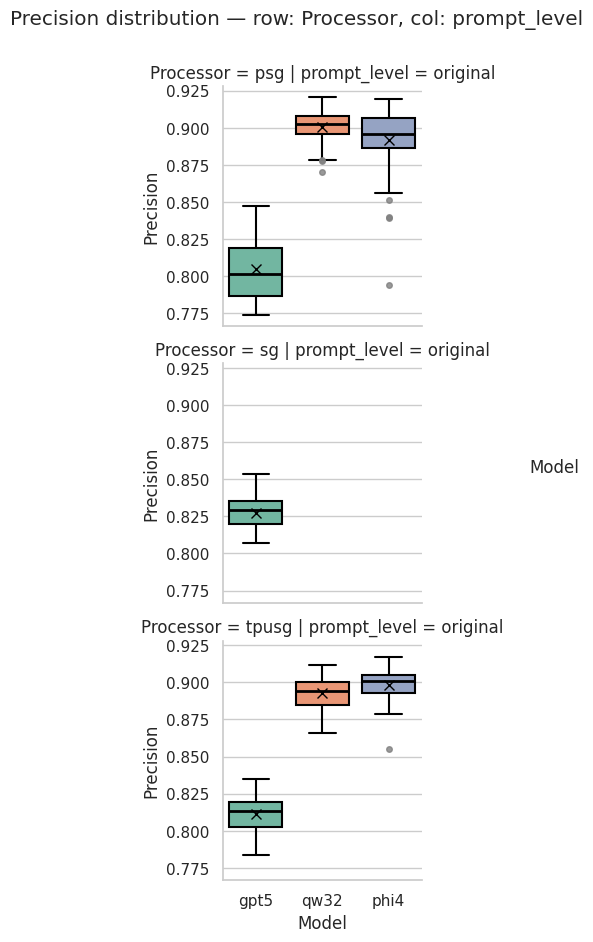

/tmp/ipykernel_2446511/3087961975.py:7: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.catplot(


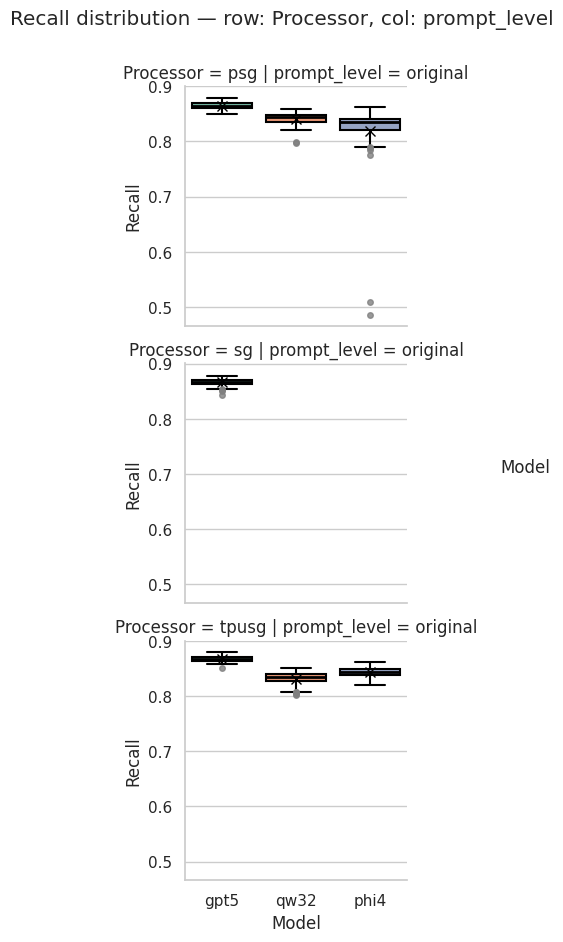

/tmp/ipykernel_2446511/3087961975.py:7: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.catplot(


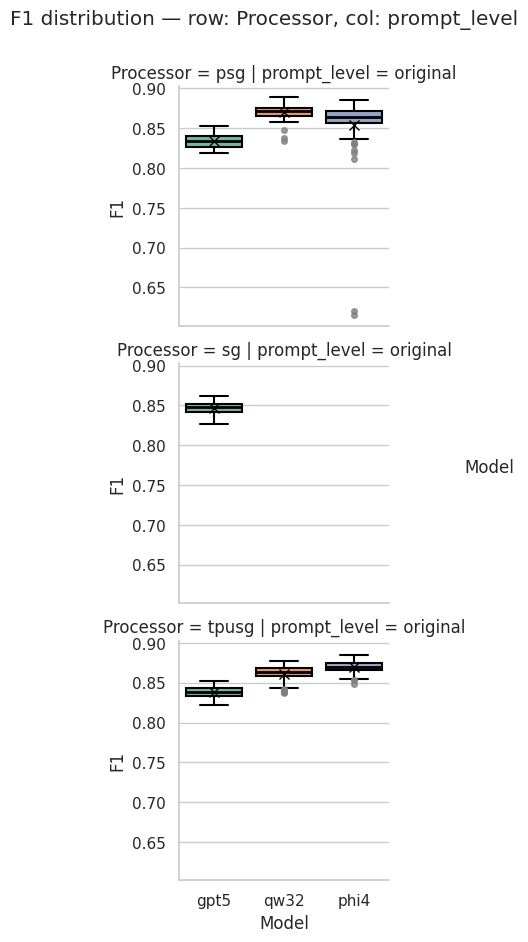

/tmp/ipykernel_2446511/3087961975.py:7: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.catplot(


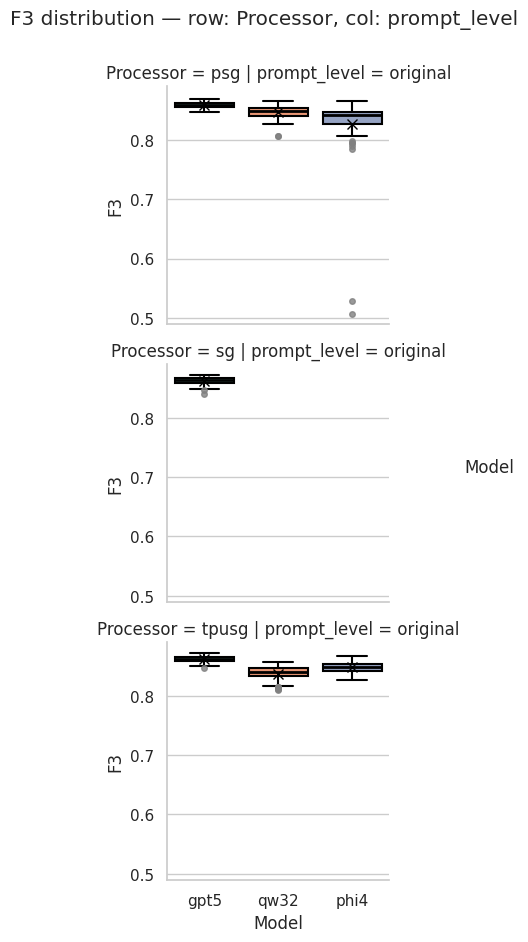

In [162]:
# 3x3 grid per metric: rows = Processor, cols = prompt_level, hue = Model
if df.empty:
    print("No data to plot.")
else:
    metrics = ["Precision", "Recall", "F1", "F3"]
    for metric in metrics:
        g = sns.catplot(
            data=df,
            x="Model",
            y=metric,
            hue="Model",
            row="Processor",
            col="prompt_level",
            kind="box",
            sharey=True,
            height=3.2,
            aspect=1.0,
            palette=COLOR_PALETTE,
            **BOX_KWARGS,
        )
        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle(f"{metric} distribution — row: Processor, col: prompt_level", y=0.98)
        # Put a single legend on top for model colors
        g.add_legend(title="Model")
        plt.show()
